In [129]:
# Core imports
import os, sys, shutil
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime, time
import seaborn as sns
from datetime import datetime
from collections import defaultdict



from scipy.stats import norm

# Basic settings
%matplotlib inline
sns.set(style="whitegrid")

# Project Dates
START_DATE = '2015-01-01'
END_DATE = '2025-04-30'

# Risk-free rate assumption
RISK_FREE_RATE = 0.02  # 2% annualized

In [16]:
# Pull table from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tables = pd.read_html(url)

# The first table contains the S&P 500 constituents
sp500_table = tables[0]

# Extract the 'Symbol' column
sp500_tickers = sp500_table['Symbol'].tolist()

# Some symbols have dots instead of dashes (e.g., BRK.B should be BRK-B for Yahoo)
sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers]

# Print first 10 tickers to check
print(sp500_tickers[:10])

# Save to CSV (optional but recommended)
ticker_list_path = "../data/sp500_tickers.csv"
pd.DataFrame(sp500_tickers, columns=["Ticker"]).to_csv(ticker_list_path, index=False)

print(f"Saved {len(sp500_tickers)} tickers to {ticker_list_path}")

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']
Saved 503 tickers to ../data/sp500_tickers.csv


In [15]:
print(f"Length of S&P500 Ticker list: {len(sp500_tickers)}")
import random
random.sample(sp500_tickers, 5)

Length of S&P500 Ticker list: 503


['SJM', 'DGX', 'IP', 'BIIB', 'EXPE']

In [23]:
DATA_DIR

'../data/stock_prices'

## Batch Stock Downloader

In [128]:
def download_sp500_with_sectors(ticker_csv_path="../data/sp500_tickers.csv",
                                 data_dir="../data/stock_prices",
                                 sector_output_path="../data/sector_map.json",
                                 missing_log_path="../data/missing_tickers.txt",
                                 start_date="2015-01-01",
                                 end_date="2024-04-30",
                                 batch_size=20,
                                 wait_time=5):
    """
    Downloads historical stock prices and sector info for tickers in sp500_tickers.csv.
    Saves each ticker's price data to CSV and writes sector info to JSON.
    """

    # Clean output directory
    if os.path.exists(data_dir):
        confirm = input(f"⚠️ WARNING: This will delete ALL existing files in {data_dir}. Continue? (yes/no): ").lower()
        if confirm != "yes":
            raise SystemExit("❌ Aborting to protect existing files.")
        shutil.rmtree(data_dir)
        print(f"🧹 Cleared old data from {data_dir}")

    os.makedirs(data_dir, exist_ok=True)

    # Load tickers
    sp500_tickers = pd.read_csv(ticker_csv_path)['Ticker'].tolist()

    # Sector map & missing ticker log
    sector_map = {}
    missing_log = open(missing_log_path, "w")

    # Download data in batches
    for i in range(0, len(sp500_tickers), batch_size):
        batch = sp500_tickers[i:i + batch_size]
        print(f"\n📦 Pulling batch {i // batch_size + 1}: {batch}")

        try:
            data = yf.download(batch, start=start_date, end=end_date, group_by='ticker', threads=True)
        except Exception as e:
            print(f"❌ Error pulling batch: {e}")
            continue

        for ticker in batch:
            try:
                if ticker not in data.columns.levels[0]:
                    print(f"❌ No data for {ticker}, skipping.")
                    missing_log.write(ticker + "\n")
                    continue

                df = data[ticker].dropna()
                if df.empty:
                    print(f"⚠️ {ticker} returned an empty DataFrame.")
                    missing_log.write(ticker + "\n")
                    continue

                df.to_csv(os.path.join(data_dir, f"{ticker}.csv"))
                print(f"✅ Saved {ticker}")

                # Grab sector info
                try:
                    info = yf.Ticker(ticker).info
                    sector = info.get("sector", "Unknown")
                    sector_map[ticker] = sector
                except Exception as e:
                    print(f"⚠️ Could not fetch sector for {ticker}: {e}")
                    sector_map[ticker] = "Unknown"

                time.sleep(0.2)  # Gentle delay
            except Exception as e:
                print(f"❌ Error saving {ticker}: {e}")

        time.sleep(wait_time)

    # Wrap-up
    missing_log.close()
    with open(sector_output_path, "w") as f:
        json.dump(sector_map, f, indent=2)
    print("\n✅ Done downloading prices and sectors!")

download_sp500_with_sectors()

🧹 Cleared old data from ../data/stock_prices

📦 Pulling batch 1: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL']


[*********************100%***********************]  20 of 20 completed


✅ Saved MMM
✅ Saved AOS
✅ Saved ABT
✅ Saved ABBV
✅ Saved ACN
✅ Saved ADBE
✅ Saved AMD
✅ Saved AES
✅ Saved AFL
✅ Saved A
✅ Saved APD
✅ Saved ABNB
✅ Saved AKAM
✅ Saved ALB
✅ Saved ARE
✅ Saved ALGN
✅ Saved ALLE
✅ Saved LNT
✅ Saved ALL
✅ Saved GOOGL

📦 Pulling batch 2: ['GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL']


[*********************100%***********************]  20 of 20 completed


✅ Saved GOOG
✅ Saved MO
✅ Saved AMZN
✅ Saved AMCR
✅ Saved AEE
✅ Saved AEP
✅ Saved AXP
✅ Saved AIG
✅ Saved AMT
✅ Saved AWK
✅ Saved AMP
✅ Saved AME
✅ Saved AMGN
✅ Saved APH
✅ Saved ADI
✅ Saved ANSS
✅ Saved AON
✅ Saved APA
✅ Saved APO
✅ Saved AAPL

📦 Pulling batch 3: ['AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX']


[*********************100%***********************]  20 of 20 completed


✅ Saved AMAT
✅ Saved APTV
✅ Saved ACGL
✅ Saved ADM
✅ Saved ANET
✅ Saved AJG
✅ Saved AIZ
✅ Saved T
✅ Saved ATO
✅ Saved ADSK
✅ Saved ADP
✅ Saved AZO
✅ Saved AVB
✅ Saved AVY
✅ Saved AXON
✅ Saved BKR
✅ Saved BALL
✅ Saved BAC
✅ Saved BAX
✅ Saved BDX


[                       0%                       ]


📦 Pulling batch 4: ['BRK-B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS']


[*********************100%***********************]  20 of 20 completed


✅ Saved BRK-B
✅ Saved BBY
✅ Saved TECH
✅ Saved BIIB
✅ Saved BLK
✅ Saved BX
✅ Saved BK
✅ Saved BA
✅ Saved BKNG
✅ Saved BSX
✅ Saved BMY
✅ Saved AVGO
✅ Saved BR
✅ Saved BRO
✅ Saved BF-B
✅ Saved BLDR
✅ Saved BG
✅ Saved BXP
✅ Saved CHRW
✅ Saved CDNS


[*****                 10%                       ]  2 of 20 completed


📦 Pulling batch 5: ['CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX']


[*********************100%***********************]  20 of 20 completed


✅ Saved CZR
✅ Saved CPT
✅ Saved CPB
✅ Saved COF
✅ Saved CAH
✅ Saved KMX
✅ Saved CCL
✅ Saved CARR
✅ Saved CAT
✅ Saved CBOE
✅ Saved CBRE
✅ Saved CDW
✅ Saved COR
✅ Saved CNC
✅ Saved CNP
✅ Saved CF
✅ Saved CRL
✅ Saved SCHW
✅ Saved CHTR
✅ Saved CVX

📦 Pulling batch 6: ['CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ']


[*********************100%***********************]  20 of 20 completed


✅ Saved CMG
✅ Saved CB
✅ Saved CHD
✅ Saved CI
✅ Saved CINF
✅ Saved CTAS
✅ Saved CSCO
✅ Saved C
✅ Saved CFG
✅ Saved CLX
✅ Saved CME
✅ Saved CMS
✅ Saved KO
✅ Saved CTSH
✅ Saved CL
✅ Saved CMCSA
✅ Saved CAG
✅ Saved COP
✅ Saved ED
✅ Saved STZ

📦 Pulling batch 7: ['CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DAY', 'DECK', 'DE']


[*********************100%***********************]  20 of 20 completed


✅ Saved CEG
✅ Saved COO
✅ Saved CPRT
✅ Saved GLW
✅ Saved CPAY
✅ Saved CTVA
✅ Saved CSGP
✅ Saved COST
✅ Saved CTRA
✅ Saved CRWD
✅ Saved CCI
✅ Saved CSX
✅ Saved CMI
✅ Saved CVS
✅ Saved DHR
✅ Saved DRI
✅ Saved DVA
✅ Saved DAY
✅ Saved DECK
✅ Saved DE


[                       0%                       ]


📦 Pulling batch 8: ['DELL', 'DAL', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DG', 'DLTR', 'D', 'DPZ', 'DASH', 'DOV', 'DOW', 'DHI', 'DTE', 'DUK', 'DD', 'EMN', 'ETN']


[*********************100%***********************]  20 of 20 completed


✅ Saved DELL
✅ Saved DAL
✅ Saved DVN
✅ Saved DXCM
✅ Saved FANG
✅ Saved DLR
✅ Saved DFS
✅ Saved DG
✅ Saved DLTR
✅ Saved D
✅ Saved DPZ
✅ Saved DASH
✅ Saved DOV
✅ Saved DOW
✅ Saved DHI
✅ Saved DTE
✅ Saved DUK
✅ Saved DD
✅ Saved EMN
✅ Saved ETN


[                       0%                       ]


📦 Pulling batch 9: ['EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EQT', 'EFX', 'EQIX', 'EQR', 'ERIE', 'ESS', 'EL', 'EG', 'EVRG']


[*********************100%***********************]  20 of 20 completed


✅ Saved EBAY
✅ Saved ECL
✅ Saved EIX
✅ Saved EW
✅ Saved EA
✅ Saved ELV
✅ Saved EMR
✅ Saved ENPH
✅ Saved ETR
✅ Saved EOG
✅ Saved EPAM
✅ Saved EQT
✅ Saved EFX
✅ Saved EQIX
✅ Saved EQR
✅ Saved ERIE
✅ Saved ESS
✅ Saved EL
✅ Saved EG
✅ Saved EVRG

📦 Pulling batch 10: ['ES', 'EXC', 'EXE', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FICO', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FI', 'F', 'FTNT']


[*********************100%***********************]  20 of 20 completed


✅ Saved ES
✅ Saved EXC
✅ Saved EXE
✅ Saved EXPE
✅ Saved EXPD
✅ Saved EXR
✅ Saved XOM
✅ Saved FFIV
✅ Saved FDS
✅ Saved FICO
✅ Saved FAST
✅ Saved FRT
✅ Saved FDX
✅ Saved FIS
✅ Saved FITB
✅ Saved FSLR
✅ Saved FE
✅ Saved FI
✅ Saved F
✅ Saved FTNT


[*****                 10%                       ]  2 of 20 completed


📦 Pulling batch 11: ['FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GE', 'GEHC', 'GEV', 'GEN', 'GNRC', 'GD', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GL', 'GDDY']


[*********************100%***********************]  20 of 20 completed


✅ Saved FTV
✅ Saved FOXA
✅ Saved FOX
✅ Saved BEN
✅ Saved FCX
✅ Saved GRMN
✅ Saved IT
✅ Saved GE
✅ Saved GEHC
✅ Saved GEV
✅ Saved GEN
✅ Saved GNRC
✅ Saved GD
✅ Saved GIS
✅ Saved GM
✅ Saved GPC
✅ Saved GILD
✅ Saved GPN
✅ Saved GL
✅ Saved GDDY

📦 Pulling batch 12: ['GS', 'HAL', 'HIG', 'HAS', 'HCA', 'DOC', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUBB', 'HUM']


[*********************100%***********************]  20 of 20 completed


✅ Saved GS
✅ Saved HAL
✅ Saved HIG
✅ Saved HAS
✅ Saved HCA
✅ Saved DOC
✅ Saved HSIC
✅ Saved HSY
✅ Saved HES
✅ Saved HPE
✅ Saved HLT
✅ Saved HOLX
✅ Saved HD
✅ Saved HON
✅ Saved HRL
✅ Saved HST
✅ Saved HWM
✅ Saved HPQ
✅ Saved HUBB
✅ Saved HUM

📦 Pulling batch 13: ['HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'INCY', 'IR', 'PODD', 'INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'INVH', 'IQV', 'IRM']


[*********************100%***********************]  20 of 20 completed


✅ Saved HBAN
✅ Saved HII
✅ Saved IBM
✅ Saved IEX
✅ Saved IDXX
✅ Saved ITW
✅ Saved INCY
✅ Saved IR
✅ Saved PODD
✅ Saved INTC
✅ Saved ICE
✅ Saved IFF
✅ Saved IP
✅ Saved IPG
✅ Saved INTU
✅ Saved ISRG
✅ Saved IVZ
✅ Saved INVH
✅ Saved IQV
✅ Saved IRM

📦 Pulling batch 14: ['JBHT', 'JBL', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K', 'KVUE', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KKR', 'KLAC', 'KHC', 'KR']


[*********************100%***********************]  20 of 20 completed


✅ Saved JBHT
✅ Saved JBL
✅ Saved JKHY
✅ Saved J
✅ Saved JNJ
✅ Saved JCI
✅ Saved JPM
✅ Saved JNPR
✅ Saved K
✅ Saved KVUE
✅ Saved KDP
✅ Saved KEY
✅ Saved KEYS
✅ Saved KMB
✅ Saved KIM
✅ Saved KMI
✅ Saved KKR
✅ Saved KLAC
✅ Saved KHC
✅ Saved KR

📦 Pulling batch 15: ['LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LII', 'LLY', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LULU', 'LYB', 'MTB', 'MPC', 'MKTX']


[*********************100%***********************]  20 of 20 completed


✅ Saved LHX
✅ Saved LH
✅ Saved LRCX
✅ Saved LW
✅ Saved LVS
✅ Saved LDOS
✅ Saved LEN
✅ Saved LII
✅ Saved LLY
✅ Saved LIN
✅ Saved LYV
✅ Saved LKQ
✅ Saved LMT
✅ Saved L
✅ Saved LOW
✅ Saved LULU
✅ Saved LYB
✅ Saved MTB
✅ Saved MPC
✅ Saved MKTX

📦 Pulling batch 16: ['MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA']


[*********************100%***********************]  20 of 20 completed


✅ Saved MAR
✅ Saved MMC
✅ Saved MLM
✅ Saved MAS
✅ Saved MA
✅ Saved MTCH
✅ Saved MKC
✅ Saved MCD
✅ Saved MCK
✅ Saved MDT
✅ Saved MRK
✅ Saved META
✅ Saved MET
✅ Saved MTD
✅ Saved MGM
✅ Saved MCHP
✅ Saved MU
✅ Saved MSFT
✅ Saved MAA
✅ Saved MRNA

📦 Pulling batch 17: ['MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE', 'NI']


[*********************100%***********************]  20 of 20 completed


✅ Saved MHK
✅ Saved MOH
✅ Saved TAP
✅ Saved MDLZ
✅ Saved MPWR
✅ Saved MNST
✅ Saved MCO
✅ Saved MS
✅ Saved MOS
✅ Saved MSI
✅ Saved MSCI
✅ Saved NDAQ
✅ Saved NTAP
✅ Saved NFLX
✅ Saved NEM
✅ Saved NWSA
✅ Saved NWS
✅ Saved NEE
✅ Saved NKE
✅ Saved NI

📦 Pulling batch 18: ['NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG']


[*********************100%***********************]  20 of 20 completed


✅ Saved NDSN
✅ Saved NSC
✅ Saved NTRS
✅ Saved NOC
✅ Saved NCLH
✅ Saved NRG
✅ Saved NUE
✅ Saved NVDA
✅ Saved NVR
✅ Saved NXPI
✅ Saved ORLY
✅ Saved OXY
✅ Saved ODFL
✅ Saved OMC
✅ Saved ON
✅ Saved OKE
✅ Saved ORCL
✅ Saved OTIS
✅ Saved PCAR
✅ Saved PKG

📦 Pulling batch 19: ['PLTR', 'PANW', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PEP', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG']


[*********************100%***********************]  20 of 20 completed


✅ Saved PLTR
✅ Saved PANW
✅ Saved PARA
✅ Saved PH
✅ Saved PAYX
✅ Saved PAYC
✅ Saved PYPL
✅ Saved PNR
✅ Saved PEP
✅ Saved PFE
✅ Saved PCG
✅ Saved PM
✅ Saved PSX
✅ Saved PNW
✅ Saved PNC
✅ Saved POOL
✅ Saved PPG
✅ Saved PPL
✅ Saved PFG
✅ Saved PG

📦 Pulling batch 20: ['PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RVTY']


[*********************100%***********************]  20 of 20 completed


✅ Saved PGR
✅ Saved PLD
✅ Saved PRU
✅ Saved PEG
✅ Saved PTC
✅ Saved PSA
✅ Saved PHM
✅ Saved PWR
✅ Saved QCOM
✅ Saved DGX
✅ Saved RL
✅ Saved RJF
✅ Saved RTX
✅ Saved O
✅ Saved REG
✅ Saved REGN
✅ Saved RF
✅ Saved RSG
✅ Saved RMD
✅ Saved RVTY


[                       0%                       ]


📦 Pulling batch 21: ['ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SW', 'SNA', 'SOLV', 'SO']


[*********************100%***********************]  20 of 20 completed

1 Failed download:
['SW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2024-04-30) (Yahoo error = "Data doesn\'t exist for startDate = 1420088400, endDate = 1714449600")')


✅ Saved ROK
✅ Saved ROL
✅ Saved ROP
✅ Saved ROST
✅ Saved RCL
✅ Saved SPGI
✅ Saved CRM
✅ Saved SBAC
✅ Saved SLB
✅ Saved STX
✅ Saved SRE
✅ Saved NOW
✅ Saved SHW
✅ Saved SPG
✅ Saved SWKS
✅ Saved SJM
⚠️ SW returned an empty DataFrame.
✅ Saved SNA
✅ Saved SOLV
✅ Saved SO


[                       0%                       ]


📦 Pulling batch 22: ['LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SMCI', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY', 'TER']


[*********************100%***********************]  20 of 20 completed


✅ Saved LUV
✅ Saved SWK
✅ Saved SBUX
✅ Saved STT
✅ Saved STLD
✅ Saved STE
✅ Saved SYK
✅ Saved SMCI
✅ Saved SYF
✅ Saved SNPS
✅ Saved SYY
✅ Saved TMUS
✅ Saved TROW
✅ Saved TTWO
✅ Saved TPR
✅ Saved TRGP
✅ Saved TGT
✅ Saved TEL
✅ Saved TDY
✅ Saved TER


[                       0%                       ]


📦 Pulling batch 23: ['TSLA', 'TXN', 'TPL', 'TXT', 'TMO', 'TJX', 'TKO', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UBER', 'UDR', 'ULTA', 'UNP']


[*********************100%***********************]  20 of 20 completed


✅ Saved TSLA
✅ Saved TXN
✅ Saved TPL
✅ Saved TXT
✅ Saved TMO
✅ Saved TJX
✅ Saved TKO
✅ Saved TSCO
✅ Saved TT
✅ Saved TDG
✅ Saved TRV
✅ Saved TRMB
✅ Saved TFC
✅ Saved TYL
✅ Saved TSN
✅ Saved USB
✅ Saved UBER
✅ Saved UDR
✅ Saved ULTA
✅ Saved UNP


[*****                 10%                       ]  2 of 20 completed


📦 Pulling batch 24: ['UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VLTO', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VTRS', 'VICI', 'V', 'VST', 'VMC', 'WRB', 'GWW', 'WAB']


[*********************100%***********************]  20 of 20 completed


✅ Saved UAL
✅ Saved UPS
✅ Saved URI
✅ Saved UNH
✅ Saved UHS
✅ Saved VLO
✅ Saved VTR
✅ Saved VLTO
✅ Saved VRSN
✅ Saved VRSK
✅ Saved VZ
✅ Saved VRTX
✅ Saved VTRS
✅ Saved VICI
✅ Saved V
✅ Saved VST
✅ Saved VMC
✅ Saved WRB
✅ Saved GWW
✅ Saved WAB

📦 Pulling batch 25: ['WBA', 'WMT', 'DIS', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WY', 'WSM', 'WMB', 'WTW', 'WDAY', 'WYNN', 'XEL', 'XYL', 'YUM']


[*********************100%***********************]  20 of 20 completed


✅ Saved WBA
✅ Saved WMT
✅ Saved DIS
✅ Saved WBD
✅ Saved WM
✅ Saved WAT
✅ Saved WEC
✅ Saved WFC
✅ Saved WELL
✅ Saved WST
✅ Saved WDC
✅ Saved WY
✅ Saved WSM
✅ Saved WMB
✅ Saved WTW
✅ Saved WDAY
✅ Saved WYNN
✅ Saved XEL
✅ Saved XYL
✅ Saved YUM


[                       0%                       ]


📦 Pulling batch 26: ['ZBRA', 'ZBH', 'ZTS']


[*********************100%***********************]  3 of 3 completed


✅ Saved ZBRA
✅ Saved ZBH
✅ Saved ZTS

✅ Done downloading prices and sectors!


In [29]:

# Get list of saved files
saved_files = os.listdir(DATA_DIR)
saved_tickers = [filename.replace('.csv', '') for filename in saved_files if filename.endswith('.csv')]

# Compare to your master list
expected_tickers = pd.read_csv("../data/sp500_tickers.csv")['Ticker'].tolist()

# Find missing tickers
missing_tickers = set(expected_tickers) - set(saved_tickers)

# Print report
print(f"✅ Downloaded {len(saved_tickers)} out of {len(expected_tickers)} tickers successfully.")
print(f"❌ Missing {len(missing_tickers)} tickers.")

if missing_tickers:
    print(f"Missing tickers: {sorted(missing_tickers)}")
else:
    print("🎉 No missing tickers! Full success.")

✅ Downloaded 502 out of 503 tickers successfully.
❌ Missing 1 tickers.
Missing tickers: ['SW']


## Rolling Volatility Calculator

In [30]:
vol_list = []

for file in os.listdir(DATA_DIR):
    if not file.endswith(".csv"):
        continue

    ticker = file.replace(".csv", "")
    path = os.path.join(DATA_DIR, file)

    try:
        df = pd.read_csv(path, parse_dates=["Date"], index_col="Date")

        # Calculate daily log returns
        df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1))

        # 30-day rolling volatility (annualized)
        df["RollingVol"] = df["LogReturn"].rolling(window=30).std() * np.sqrt(252)

        # Drop NaNs, keep only necessary columns
        temp = df[["RollingVol"]].dropna().copy()
        temp["Ticker"] = ticker
        temp.reset_index(inplace=True)

        vol_list.append(temp)

    except Exception as e:
        print(f"⚠️ Error processing {ticker}: {e}")


## Volatility Summary

In [31]:
# Combine into single DataFrame
vol_df = pd.concat(vol_list, ignore_index=True)

# Save for screening later
vol_df.to_csv("../data/volatility_summary.csv", index=False)

print("✅ Saved volatility summary.")
print(vol_df.head())


✅ Saved volatility summary.
        Date  RollingVol Ticker
0 2015-02-17    0.268314      A
1 2015-02-18    0.271522      A
2 2015-02-19    0.268680      A
3 2015-02-20    0.271508      A
4 2015-02-23    0.259109      A


### Check

In [45]:
VOL_FILEPATH = "../data/volatility_summary.csv"
print("#Test 1 - File exists")
assert os.path.exists(VOL_FILEPATH)

print("\n#Test 2 - Inspection")
vol_df = pd.read_csv(VOL_FILEPATH)
print(f"Shape of file: {vol_df.shape}")
display(vol_df.head())

print("\n#Test 3 - Corrupt rows:")
print(f"NaNs:\n{vol_df.isna().sum()}")

print("\n#Test 4 - Sanity check on Rolling vols")
display(vol_df["RollingVol"].describe())

print("\n#Test 5 - spot Check")
display(vol_df[vol_df["Ticker"] == "SMCI"].tail())

print("\n#Test 6 - Number of Uniques")
display(vol_df["Ticker"].nunique())



#Test 1 - File exists

#Test 2 - Inspection
Shape of file: (1128473, 3)


,Date,RollingVol,Ticker
0,2015-02-17,0.268314,A
1,2015-02-18,0.271522,A
2,2015-02-19,0.268680,A
3,2015-02-20,0.271508,A
4,2015-02-23,0.259109,A



#Test 3 - Corrupt rows:
NaNs:
Date          0
RollingVol    0
Ticker        0
dtype: int64

#Test 4 - Sanity check on Rolling vols


count    1.128473e+06
mean     2.831796e-01
std      1.679164e-01
min      0.000000e+00
25%      1.831784e-01
50%      2.438964e-01
75%      3.290698e-01
max      3.180735e+00
Name: RollingVol, dtype: float64


#Test 5 - spot Check


,Date,RollingVol,Ticker
924524,2024-04-23,1.047789,SMCI
924525,2024-04-24,1.016075,SMCI
924526,2024-04-25,1.024313,SMCI
924527,2024-04-26,1.057123,SMCI
924528,2024-04-29,1.056050,SMCI



#Test 6 - Number of Uniques


500

In [52]:
# Load rolling volatility summary
vol_df = pd.read_csv("../data/volatility_summary.csv")
vol_df["Date"] = pd.to_datetime(vol_df["Date"])

# Preview
vol_df.head()

,Date,RollingVol,Ticker
0,2015-02-17,0.268314,A
1,2015-02-18,0.271522,A
2,2015-02-19,0.268680,A
3,2015-02-20,0.271508,A
4,2015-02-23,0.259109,A


### Latest Vol

In [54]:
# Get the latest date for each ticker
latest_vol = vol_df.sort_values("Date").groupby("Ticker").tail(1)
# Sanity check
print(f"Retrieved latest vol for {latest_vol.shape[0]} tickers.")
latest_vol.head()

Retrieved latest vol for 500 tickers.


,Date,RollingVol,Ticker
1082152,2024-04-29,0.141732,WDAY
817248,2024-04-29,0.192365,PCG
7767,2024-04-29,0.260405,ABNB
451146,2024-04-29,0.155377,GILD
65667,2024-04-29,0.190422,AMGN


### Selection

In [56]:
## TODO: we will change this to Vol Breakouts...

top_10pct = latest_vol.sort_values("RollingVol", ascending=False)
cutoff = int(0.10 * len(top_10pct))

top_vol_stocks = top_10pct.head(cutoff)
print(f"Selected top {cutoff} most volatile stocks.")
display(top_vol_stocks.head())

top_vol_stocks[["Ticker", "Date", "RollingVol"]].to_csv(
    "../data/high_vol_stocks.csv", index=False
)

print("✅ Saved top 10% high-volatility tickers to high_vol_stocks.csv")

Selected top 50 most volatile stocks.


,Date,RollingVol,Ticker
455778,2024-04-29,2.357481,GL
924528,2024-04-29,1.056050,SMCI
807984,2024-04-29,0.857265,PARA
1010220,2024-04-29,0.705467,TSLA
652797,2024-04-29,0.675051,LW


✅ Saved top 10% high-volatility tickers to high_vol_stocks.csv


## Visualisations

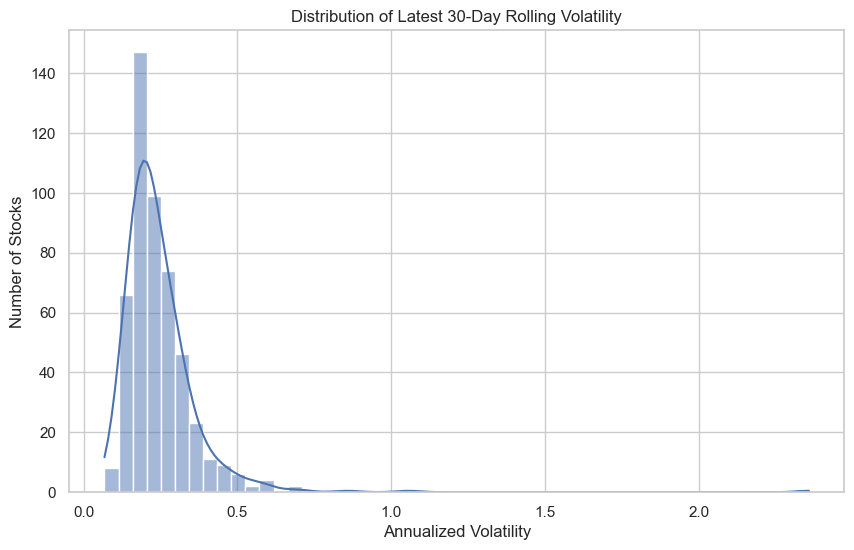

In [ ]:


plt.figure(figsize=(10, 6))
sns.histplot(latest_vol["RollingVol"], bins=50, kde=True)
plt.title("Distribution of Latest 30-Day Rolling Volatility")
plt.xlabel("Annualized Volatility")
plt.ylabel("Number of Stocks")
plt.grid(True)
plt.show()


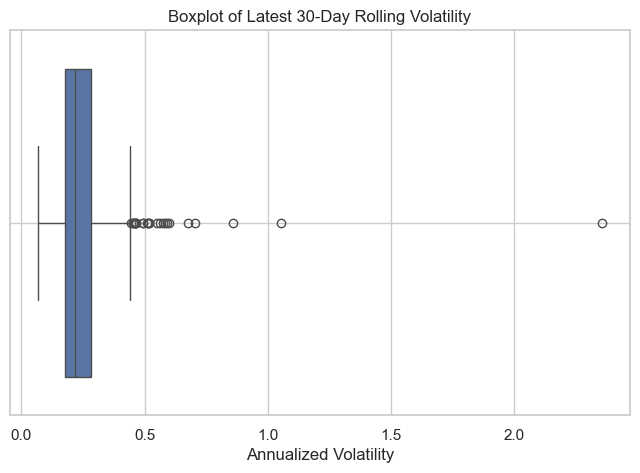

In [48]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=latest_vol["RollingVol"])
plt.title("Boxplot of Latest 30-Day Rolling Volatility")
plt.xlabel("Annualized Volatility")
plt.grid(True)
plt.show()

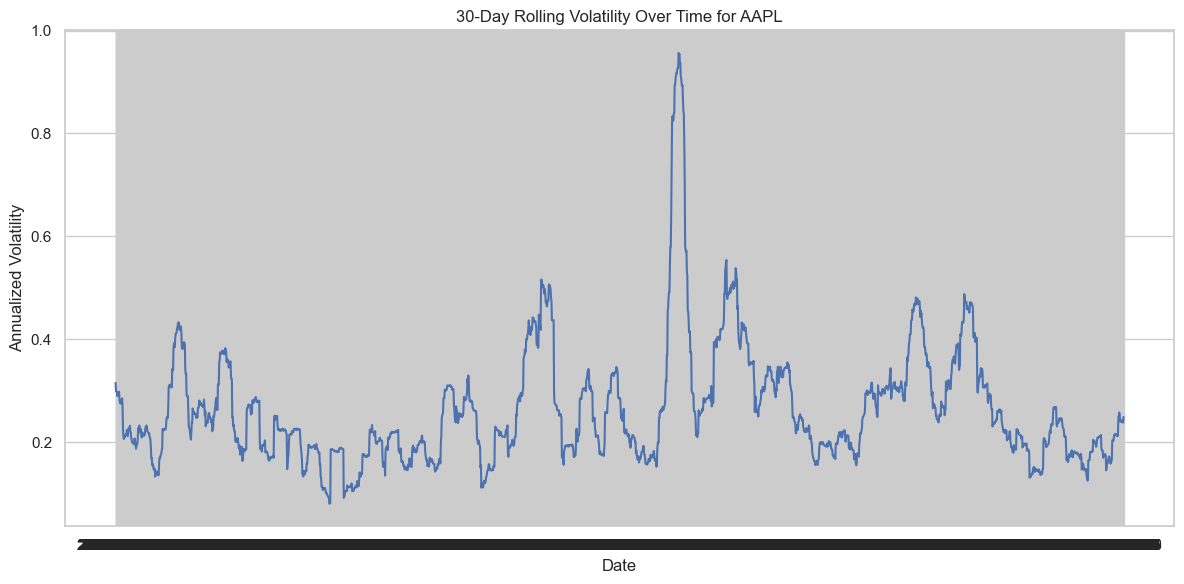

In [49]:
ticker = "AAPL"
df_plot = vol_df[vol_df["Ticker"] == ticker]

plt.figure(figsize=(12, 6))
plt.plot(df_plot["Date"], df_plot["RollingVol"])
plt.title(f"30-Day Rolling Volatility Over Time for {ticker}")
plt.ylabel("Annualized Volatility")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\glade\AppData\Local\Temp\ipykernel_22312\2904340361.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25, x="RollingVol", y="Ticker", palette="rocket")


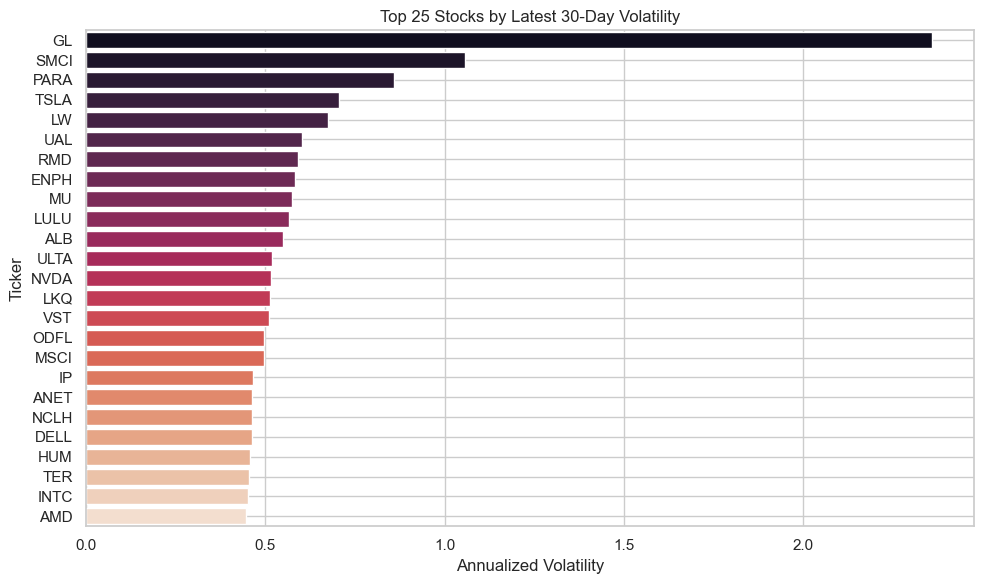

In [51]:
top_25 = latest_vol.sort_values("RollingVol", ascending=False).head(25)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_25, x="RollingVol", y="Ticker", palette="rocket")
plt.title("Top 25 Stocks by Latest 30-Day Volatility")
plt.xlabel("Annualized Volatility")
plt.ylabel("Ticker")
plt.grid(True)
plt.tight_layout()
plt.show()

## Load High Vol Stocks

In [57]:
import pandas as pd
import os

# Load screened high-vol stocks
high_vol = pd.read_csv("../data/high_vol_stocks.csv")

# Pick one ticker to test
ticker = high_vol["Ticker"].iloc[0]
print(f"Simulating for: {ticker}")

# Load that stock's price data
price_path = f"../data/stock_prices/{ticker}.csv"
df = pd.read_csv(price_path, parse_dates=["Date"])
df = df.sort_values("Date").set_index("Date")

df = df[["Close"]]  # Keep it simple
df.head()


Simulating for: GL


,Close
Date,
2015-01-02,49.653324
2015-01-05,48.764046
2015-01-06,48.103958
2015-01-07,48.158966
2015-01-08,48.901569


## Black Scholes

In [74]:
from scipy.stats import norm
import numpy as np

def black_scholes_call_price(S, K, T, r, sigma):
    """
    Black-Scholes formula for a European call option.

    Parameters:
    - S: Spot price (entry price of the stock)
    - K: Strike price (OTM call)
    - T: Time to maturity (in years)
    - r: Risk-free rate (e.g., 0.02)
    - sigma: Volatility (annualized)

    Returns:
    - Call option price (fair value)
    """
    if T <= 0 or sigma <= 0:
        return 0.0  # Handle edge cases
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


## Simulation

In [114]:
def simulate_buy_write(df, notional, call_otm_pct=0.02, option_days=21,vol_lookback_days=30):
    """
    Simulates a buy-write strategy on a single stock DataFrame.
    
    Parameters:
    - df: DataFrame with Date index and a 'Close' column
    - call_otm_pct: Percentage above spot to set the strike price
    - option_days: Holding period in trading days (approx 21 for 1 month)

    Returns:
    - DataFrame of trade-level results
    """

    trades = []

    df = df.sort_index()  # Ensure date order
    returns = df["Close"].pct_change().rolling(vol_lookback_days).std() * np.sqrt(252)

    valid_start = vol_lookback_days + 1
    i = valid_start
    while i < len(df) - option_days:
        
        # Parameters
        T = option_days / 252
        r = 0.02  # risk-free rate
        sigma = returns.iloc[i]  # historical vol proxy

        entry_date = df.index[i]
        expiry_date = df.index[i + option_days]

        entry_price = df["Close"].iloc[i]
        spot_price_close = df["Close"].iloc[i + option_days]
        strike = entry_price * (1 + call_otm_pct)

        # Defensive handling
        if np.isnan(sigma) or sigma <= 0:
            premium = 0.0
        else:
            premium = black_scholes_call_price(entry_price, strike, T, r, sigma)
        
        if spot_price_close > strike:
            # Option is in the money, stock is called away at strike
            exit_price = strike
            outcome = "Called"
            pnl_stock = strike - entry_price
            pnl_unrealized = 0
            pnl_realized = pnl_stock + premium
        else:
            # Option expires OTM, you keep the stock
            exit_price = spot_price_close
            outcome = "Not Called"
            pnl_stock = spot_price_close - entry_price
            pnl_unrealized = pnl_stock
            pnl_realized = premium

        pnl_call = premium
        pnl_total = pnl_call + pnl_stock
        pnl_percent = pnl_total / notional
        quantity = notional / entry_price

        trades.append({
            "NumberShares":quantity,
            "EntryDate": entry_date,
            "EntryPrice": entry_price,
            "ExpiryDate": expiry_date,
            "ExitPrice": exit_price,  # Actual exit execution price
            "SpotPrice_Close": spot_price_close,
            "Strike": strike,
            "Premium": premium,
            "Outcome": outcome,
            "PnL_Call": pnl_call,
            "PnL_Stock": pnl_stock,
            "PnL_Realized": pnl_realized,
            "PnL_Unrealized": pnl_unrealized,
            "PnL_Total": pnl_total,
            "PnL_Percent": pnl_percent,
            "PnL_Call_Position": pnl_call * quantity,
            "PnL_Stock_Position": pnl_stock * quantity,
            "PnL_Realized_Position": pnl_realized * quantity,
            "PnL_Unrealized_Position": pnl_unrealized * quantity,
            "PnL_Total_position": pnl_total * quantity,
        })

        i += option_days  # Move to next round

    return pd.DataFrame(trades)


In [115]:
results = simulate_buy_write(df,notional=10_000)
results.head()

,NumberShares,EntryDate,EntryPrice,ExpiryDate,ExitPrice,SpotPrice_Close,Strike,Premium,Outcome,PnL_Call,PnL_Stock,PnL_Realized,PnL_Unrealized,PnL_Total,PnL_Percent,PnL_Call_Position,PnL_Stock_Position,PnL_Realized_Position,PnL_Unrealized_Position,PnL_Total_position
0,203.008199,2015-02-18,49.259094,2015-03-19,50.244276,50.331749,50.244276,0.615658,Called,0.615658,0.985182,1.600840,0.000000,1.600840,0.000160,124.983623,200.000000,324.983623,0.000000,324.983623
1,198.681751,2015-03-19,50.331749,2015-04-20,51.338384,52.072613,51.338384,0.358550,Called,0.358550,1.006635,1.365185,0.000000,1.365185,0.000137,71.237437,200.000000,271.237437,0.000000,271.237437
2,192.039528,2015-04-20,52.072613,2015-05-19,52.991642,52.991642,53.114065,0.344876,Not Called,0.344876,0.919029,0.344876,0.919029,1.263905,0.000126,66.229759,176.489941,66.229759,176.489941,242.719700
3,188.709004,2015-05-19,52.991642,2015-06-18,54.051475,54.168011,54.051475,0.196697,Called,0.196697,1.059833,1.256530,0.000000,1.256530,0.000126,37.118478,200.000000,237.118478,0.000000,237.118478
4,184.610804,2015-06-18,54.168011,2015-07-20,55.251371,55.621258,55.251371,0.220724,Called,0.220724,1.083360,1.304084,0.000000,1.304084,0.000130,40.748060,200.000000,240.748060,0.000000,240.748060


## Simulation Loop

In [116]:
import os
import pandas as pd

def run_simulations_on_ticker_list(ticker_list, price_dir, output_path, simulation_func):
    """
    Runs a buy-write simulation across a list of tickers and writes combined results.

    Parameters:
    - ticker_list: List of tickers
    - price_dir: Path to folder with individual .csv price files
    - output_path: Where to save combined trade log
    - simulation_func: The buy-write simulation function to use
    """

    all_trades = []

    for ticker in ticker_list:
        file_path = os.path.join(price_dir, f"{ticker}.csv")
        if not os.path.exists(file_path):
            print(f"⚠️ File not found: {file_path}")
            continue

        try:
            df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
            df = df.sort_index()
            trades = simulation_func(df)
            trades["Ticker"] = ticker
            all_trades.append(trades)

        except Exception as e:
            print(f"❌ Error processing {ticker}: {e}")
            continue

    # Combine and save
    combined = pd.concat(all_trades, ignore_index=True)
    combined.to_csv(output_path, index=False)
    print(f"✅ Saved combined trade log to: {output_path}")
    return combined


In [117]:
# Load your top-vol ticker list
tickers_df = pd.read_csv("../data/high_vol_stocks.csv")
top_tickers = tickers_df["Ticker"].unique().tolist()

# Run the simulation across all tickers
trade_log = run_simulations_on_ticker_list(
    ticker_list=top_tickers,
    price_dir="../data/stock_prices",
    output_path="../data/trade_log.csv",
    simulation_func=simulate_buy_write
)

❌ Error processing GL: simulate_buy_write() missing 1 required positional argument: 'notional'
❌ Error processing SMCI: simulate_buy_write() missing 1 required positional argument: 'notional'
❌ Error processing PARA: simulate_buy_write() missing 1 required positional argument: 'notional'
❌ Error processing TSLA: simulate_buy_write() missing 1 required positional argument: 'notional'
❌ Error processing LW: simulate_buy_write() missing 1 required positional argument: 'notional'
❌ Error processing UAL: simulate_buy_write() missing 1 required positional argument: 'notional'
❌ Error processing RMD: simulate_buy_write() missing 1 required positional argument: 'notional'
❌ Error processing ENPH: simulate_buy_write() missing 1 required positional argument: 'notional'
❌ Error processing MU: simulate_buy_write() missing 1 required positional argument: 'notional'
❌ Error processing LULU: simulate_buy_write() missing 1 required positional argument: 'notional'
❌ Error processing ALB: simulate_buy_w

ValueError: No objects to concatenate

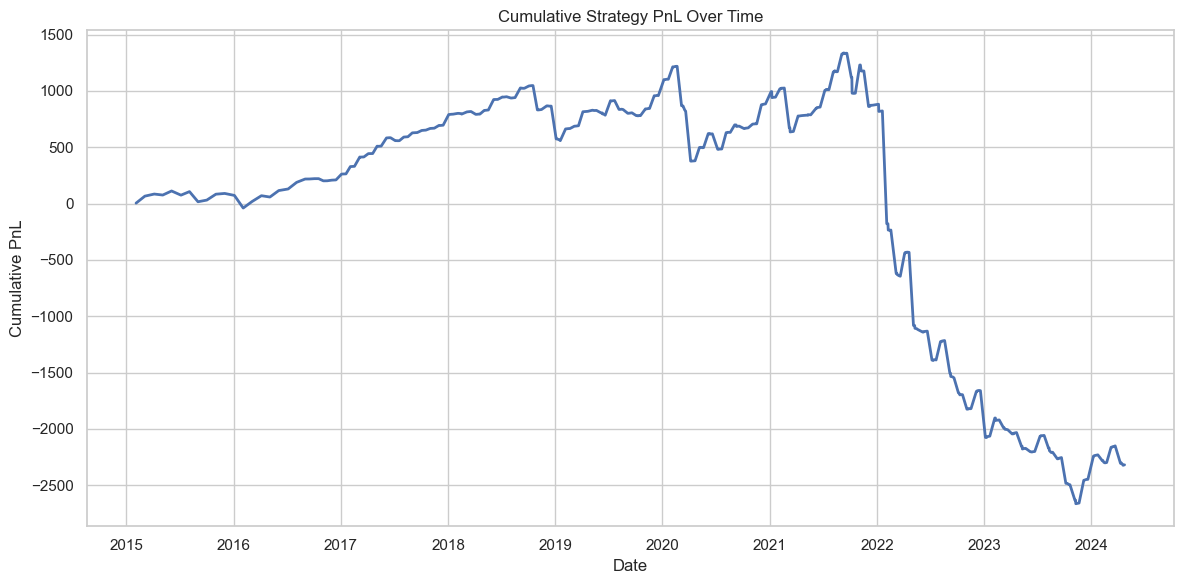

In [ ]:
# Sort and group by date
daily_pnl = trade_log.groupby("ExpiryDate")["PnL_Total"].sum().cumsum()

plt.figure(figsize=(12, 6))
plt.plot(daily_pnl.index, daily_pnl.values, linewidth=2)
plt.title("Cumulative Strategy PnL Over Time")
plt.ylabel("Cumulative PnL")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


# Portfolio Simulator Class

In [ ]:
class BuyWritePortfolioSimulator:
    def __init__(self, 
                 vol_summary_df,       # Full volatility summary (w/ vol breakouts)
                 price_dir,            # Path to stock price files
                 notional_per_trade=10000,
                 num_positions=5,
                 option_days=21,
                 sector_limit=3):
        
        os.makedirs("../logs", exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file_path = f"../logs/buywrite_log_{timestamp}.txt"

        with open("../data/sector_map.json") as f:
            self.ticker_sector_map = json.load(f)

        
        self.vol_summary_df = vol_summary_df.copy()
        self.price_dir = price_dir
        self.notional = notional_per_trade
        self.num_positions = num_positions
        self.option_days = option_days
        self.sector_limit = sector_limit
        self.summary_log = []
        self.active_positions = []  # list of dicts for each open position
        self.trade_log = []         # stores all completed trades
        self.date_index = sorted(vol_summary_df["Date"].unique())
        
    def _screen_high_vol(self, current_date, exclude_tickers=None):
        """
        Return ranked list of high-vol tickers on a given date,
        excluding any that would violate the sector cap.
        """
        df = self.vol_summary_df
        exclude = set(exclude_tickers or [])

        # Count existing sector allocations
        sector_counts = defaultdict(int)
        for pos in self.active_positions:
            ticker = pos["Ticker"]
            sector = self.ticker_sector_map.get(ticker, "Unknown")
            sector_counts[sector] += 1

        # Screen candidates by volatility
        day_data = df[df["Date"] == current_date]
        tickers_ranked = (
            day_data[~day_data["Ticker"].isin(exclude)]
            .sort_values("RollingVol", ascending=False)["Ticker"]
            .tolist()
        )

        selected = []
        for ticker in tickers_ranked:
            sector = self.ticker_sector_map.get(ticker, "Unknown")
            if sector_counts[sector] < self.sector_limit:
                selected.append(ticker)
                sector_counts[sector] += 1
            if len(selected) >= self.num_positions:
                break

        return selected

    def _load_price_data(self, ticker):
        """Loads the price CSV for a given ticker."""
        try:
            df = pd.read_csv(f"{self.price_dir}/{ticker}.csv", parse_dates=["Date"])
            df = df.set_index("Date").sort_index()
            return df
        except Exception as e:
            print(f"❌ Failed to load data for {ticker}: {e}")
            return None

    def _enter_position(self, ticker, entry_date):
        """Simulate a new buy-write position on entry_date for a given ticker."""
        df = self._load_price_data(ticker)
        if df is None or entry_date not in df.index:
            return None

        # Slice from entry date forward
        sub_df = df[df.index >= entry_date].copy()
        if len(sub_df) < self.option_days:
            return None  # Not enough data to simulate a round

        # Run simulation for this trade window
        trade_df = simulate_buy_write(sub_df, 
                                    notional=self.notional, 
                                    option_days=self.option_days)

        if trade_df.empty:
            return None

        # Keep only the first trade (single 1-month round)
        trade = trade_df.iloc[0].to_dict()
        trade["Ticker"] = ticker
        self.active_positions.append(trade)

        
    def _roll_or_replace(self, expiry_date):
        """Manage expiring positions: roll or replace."""
        new_positions = []
        exited = []
        rolled = []
        replaced = []
        new_buys = []
        pnl_this_round = 0.0

        for pos in self.active_positions:
            if pd.to_datetime(pos["ExpiryDate"]) != expiry_date:
                new_positions.append(pos)
                continue

            self.trade_log.append(pos)
            pnl_this_round += pos["PnL_Total_position"]
            exited.append(pos["Ticker"])

            if pos["Outcome"] == "Called":
                replaced.append(pos["Ticker"])
            else:
                # Roll same stock forward
                rolled.append(pos["Ticker"])
                self._enter_position(pos["Ticker"], expiry_date)

        self.active_positions = new_positions

        # Fill vacant slots with new names
        used_tickers = {pos["Ticker"] for pos in self.active_positions}
        candidates = self._screen_high_vol(expiry_date, exclude_tickers=used_tickers)

        for ticker in candidates:
            if len(self.active_positions) >= self.num_positions:
                break
            self._enter_position(ticker, expiry_date)
            new_buys.append(ticker)

        # 📝 One log entry per expiry
        from datetime import datetime
        summary_lines = []
        summary_lines.append(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] 📆 Expiry Date: {expiry_date.date()}")

        if rolled:
            summary_lines.append("🔁 Rolled Positions:")
            for ticker in rolled:
                try:
                    shares = next(p for p in self.active_positions if p["Ticker"] == ticker)["NumberShares"]
                    summary_lines.append(f"   - {ticker}: {shares:.4f} shares")
                except StopIteration:
                    summary_lines.append(f"   - {ticker}: N/A")

        if replaced:
            summary_lines.append("✅ Called Away (Exited): " + ", ".join(replaced))

        if new_buys:
            summary_lines.append("🛒 New Positions:")
            for ticker in new_buys:
                try:
                    shares = next(p for p in self.active_positions if p["Ticker"] == ticker)["NumberShares"]
                    summary_lines.append(f"   - {ticker}: {shares:.4f} shares")
                except StopIteration:
                    summary_lines.append(f"   - {ticker}: N/A")

        summary_lines.append(f"💰 Period PnL: ${pnl_this_round:,.2f}")
        summary_lines.append("─" * 60)
        summary_lines.append(f"🏛 Sector Mix: {dict(sector_counts)}")

        # Write to log file
        with open(self.log_file_path, "a") as f:
            f.write("\n".join(summary_lines) + "\n\n")

                    
    def run(self):
        """Run the simulation from start to finish, stepping only on expiry dates."""
        # Initialize first portfolio
        first_valid_date = self.date_index[0]
        starting_tickers = self._screen_high_vol(first_valid_date)[:self.num_positions]
        for ticker in starting_tickers:
            self._enter_position(ticker, first_valid_date)

        # Keep track of upcoming expiry dates from active positions
        expiry_schedule = sorted({pd.to_datetime(p["ExpiryDate"]) for p in self.active_positions})

        while expiry_schedule:
            next_expiry = expiry_schedule.pop(0)

            self._roll_or_replace(next_expiry)

            # Add new expiry dates from updated active positions
            new_expiries = {pd.to_datetime(p["ExpiryDate"]) for p in self.active_positions}
            expiry_schedule = sorted(set(expiry_schedule).union(new_expiries))

        return pd.DataFrame(self.trade_log)



### Portfolio Run

In [126]:
vol_summary = pd.read_csv("../data/volatility_summary.csv", parse_dates=["Date"])
sim = BuyWritePortfolioSimulator(vol_summary_df=vol_summary,
                                  price_dir="../data/stock_prices",
                                  notional_per_trade=10_000,
                                  num_positions=5)

portfolio_results = sim.run()
portfolio_results.to_csv("../data/rotating_trade_log.csv", index=False)
